# Weighted Finite State Transducers

Weighted Finite State Transducers are a powerful generalization of...

- hidden Markov models
- finite state machines
- regular expressions

Many algorithms that are quite a bit of work to implement "manually" can be expressed 
as simple operations on weighted finite state transducers, including:

- Viterbi
- forward-backward
- union, intersection, composition, closure, etc.

The OpenFST library is one of the most efficient and widely used libraries for weighted finite state transducers.
It is being used with very large language models and works quite reliably.

All the examples given here are using Python bindings to the OpenFST library.

The original OpenFST library is in C++, and some of the C++ design and behavior is reflected in the Python bindings.
Most importantly, many errors will simply terminate the OpenFST process, and with it the Python process
(hopefully, better error handling hooks will be in the next release of OpenFST).

You can also use OpenFST directly from C++, and from the command line as well.


# Preliminaries

In [43]:
from pylab import *
import openfst
from openfst import StdVectorFst as FST
from fstutils import *
figsize(12,4)

A simple function to read out a label sequence.
`openfst.GetString` does something similar.

In [44]:
def label_seq(fst,which=1,full=0):
    result = []
    total = 0
    state = fst.Start()
    while not fst.IsFinal(state):
        assert fst.NumArcs(state)==1
        a = fst.GetArc(state,0)
        if which==0: l = a.ilabel
        else: l = a.olabel
        result.append(l)
        total += a.weight.Value()
        state = a.nextstate
    result = [chr(c) for c in result if c>=32]
    if full:
        return result,total
    else:
        return "".join(result)

Before actually starting with the finite state transducers, let's
first introduce the symbol table class.
Internally, all inputs and outputs in the openfst library are
integers, but for printing, that's not all that convenient.
So, instead, we have a table that translates back and forth.
For all these examples, we're just going to use ASCII characters.
Symbol tables are stored with the transducers, allowing them
to be interpreted even after saving.

In [45]:
ASCII = openfst.SymbolTable("ASCII")
for i in range(127):
    if i==0:
        ASCII.AddSymbol("ϵ",i)
    elif i<=32: 
        ASCII.AddSymbol("$%02x"%i,i)
    else:
        ASCII.AddSymbol(chr(i),i)

# Language Models

Although we are going to spend a lot of time talking about the details
of finite state transducers, it is important to keep in mind that
a finite state transducer is really just a **large set of strings**
with associated costs. 

A simple language model can be implemented without all that
machinery like, for example like this:

In [46]:
class FiniteLanguageModel:
    def __init__(self,strings):
        self.strings = strings
    def cost(self,s):
        return self.strings.get(s,inf)

In [47]:
lm = FiniteLanguageModel({"hello":1.0,"world":1.5})
lm.cost("hello")

1.0

The second aspect of finite state transducers as language models is that they can be manipulated
as objects in their own right. So, we can take two language models and combine them in some way.
Here is a simple high level example:

In [48]:
class UnionLanguageModel:
    def __init__(self,u,v):
        self.u = u
        self.v = v
    def cost(self,s):
        return min(self.u.cost(s),self.v.cost(s))

In [49]:
lm2 = FiniteLanguageModel({"the":0.5,"fox":0.7})
lm3 = UnionLanguageModel(lm,lm2)
lm3.cost("fox")

0.7

Language models are a key part of speech recognition, handwriting recognition, and OCR.

You can think of the recognition process as being divided into two parts:

- the low-level recognizer analyzes sound or images and outputs a collection of recognition hypotheses with associated costs/probabilities
- each recognition hypothesis is tested for its presence in the language model
- the costs of the recognition hypothesis are combined with the costs from the language model
- the result that has the lowest combined cost is returned by the system

In principle, this seems straightforward, but the number of recognition hypotheses and
the number of possible strings in the language model grows exponentially in the length of the input.

This means that we need efficient algorithms for computing with these collections of strings.

Weighted finite state transducers really give us a collection of capabilities:

- they compact the set of strings in something like a finite language model into a small, efficient data structure
- they allow statistically correct combinations of costs (where costs represent log proabilities)
- they allow statistically correct combinations of multiple language models
- they can represent infinite sets of strings
- they can perform *transductions*: mappings from input strings to output strings with associated costs

# Basic FST Construction

FST objects represent directed graphs in the form of a ragged array of nodes.

In [50]:
fst = FST()

In [51]:
states = [fst.AddState() for i in range(3)]

In [52]:
def make_string_fst(s):
    fst = FST()
    states = [fst.AddState() for i in range(len(s)+1)]
    fst.SetStart(states[0])
    for i,c in enumerate(s):
        fst.AddArc(i,ord(c),ord(c),0.0,i+1)
    fst.SetFinal(len(s),0.0)
    return fst

In [53]:
fst1 = make_string_fst("hello")

In [54]:
arc = fst1.GetArc(0,0)
arc.weight.Value()

0.0

The important parts of this data structure are:

- The fst consists of a list of states; you need to add new states with `AddState()`
- States are identified by integers; the total number of states is `NumStates()`.
- Trying to use a non-existent state or arc will result in a segmentation fault (the underlying library is C++ w/o error checking)
- Each state can be a start state (only one), and/or an accept state, optionally with an accept cost.

For the arcs, you should know:

- For each state, there is a list of arcs.
- You can find the number of arcs with `NumArcs(state)`
- You can get the i'th arc with `GetArc(state,i)`
- Once you have an arc, it has properties `ilabel`, `olabel`, `weight`, and `nextstate`
- The `weight` itself is an instance of a class. To get the numerical weight, use the `Value()` method on it.

Let's illustrate this with a function that actually draws an FST.

In [55]:
def show_fst(fst):
    import pydot,pylab
    graph = pydot.Dot(rankdir="LR")
    isyms = fst.InputSymbols()
    if not isyms: isyms = ASCII
    osyms = fst.OutputSymbols()
    if not osyms: osyms = ASCII
    for s in range(fst.NumStates()):
        if s==fst.Start():
            n = pydot.Node("%d"%s,shape="box")
            graph.add_node(n)
        if fst.IsFinal(s):
            l = '"'
            l += "%d"%s # node id
            if fst.Final(s).Value()!=0.0: # optional non-zero accept cost
                l += "/%s"%fst.Final(s).Value()
            l += '"'
            n = pydot.Node("%d"%s,label=l,penwidth="3")
            graph.add_node(n)
        for t in range(fst.NumArcs(s)):
            a = fst.GetArc(s,t)
            l = '"'
            l += '%s'%isyms.Find(a.ilabel)
            if a.olabel!=a.ilabel: l += ":%s"%osyms.Find(a.olabel)
            v = a.weight.Value()
            if v!=0.0: l += "/%s"%v
            l += '"'
            n = a.nextstate
            e = pydot.Edge("%d"%s,"%d"%n,label=l)
            graph.add_edge(e)
    graph.write_png("/tmp/_test.png")
    pylab.gca().set_xticks([]); pylab.gca().set_yticks([])
    pylab.clf()
    pylab.imshow(pylab.imread("/tmp/_test.png"))   

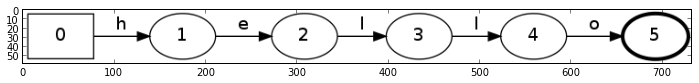

In [56]:
show_fst(fst1)

In [57]:
def make_rstring_fst(s):
    fst = FST()
    states = [fst.AddState() for i in range(len(s)+1)]
    fst.SetStart(states[0])
    for i,c in enumerate(s):
        fst.AddArc(i,ord(c),ord(c),0.0,i+1)
        fst.AddArc(i,ord(c),ord(c),0.0,i)
    fst.SetFinal(len(s),0.0)
    return fst

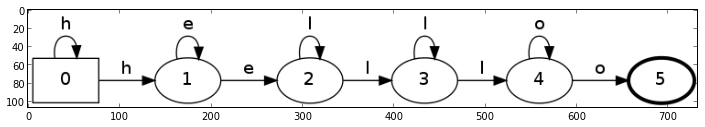

In [58]:
fst2 = make_rstring_fst("hello")
show_fst(fst2)

# Built-In Constructors for Strings

There are some built-in constructors that make it easy to add strings to finite state transducers.

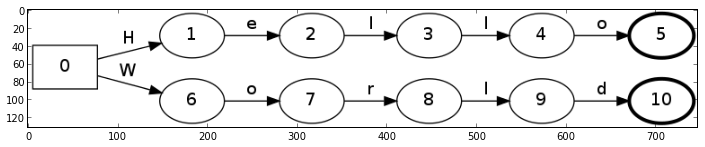

In [59]:
fst = FST()
fst.AddString("Hello")
fst.AddString("World")
show_fst(fst)

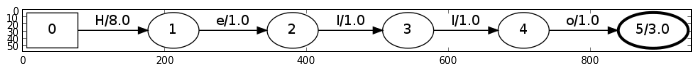

In [60]:
fst = FST()
fst.AddString("Hello",7.0,3.0,1.0)
show_fst(fst)

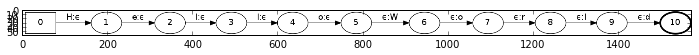

In [61]:
fst = FST()
fst.AddTranslation("Hello","World")
show_fst(fst)

# Union, Concatenation, ... and Epsilon

Finite state transducers are closely related to regular expressions,
and there are a number of things we can do with regular expressions,
such as concatenating them, making closures, etc. Several of these operations are built into openfst.

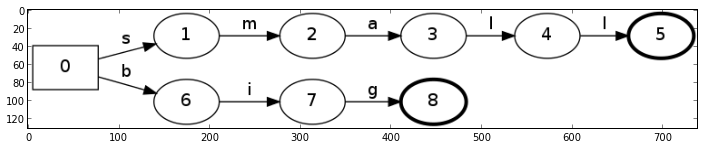

In [62]:
figsize(12,4)
a = FST()
a.AddString("small")
a.AddString("big")
show_fst(a)

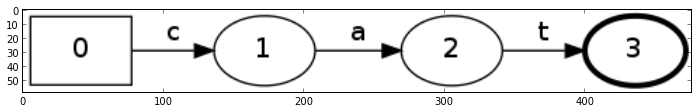

In [63]:
b = FST()
b.AddString("cat")
show_fst(b)

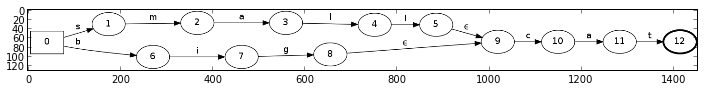

In [64]:
openfst.ConcatOnto(a,b)
show_fst(a)

Note the use of the epsilon symbol on arcs connecting the first and the second transducer.

The epsilon symbol on a transducer consumes no input and produces no output.
It just connects two states.

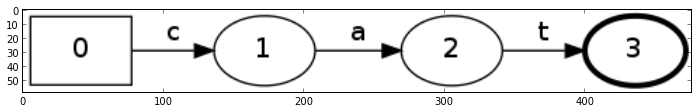

In [65]:
a = FST()
a.AddString("cat")
show_fst(a)

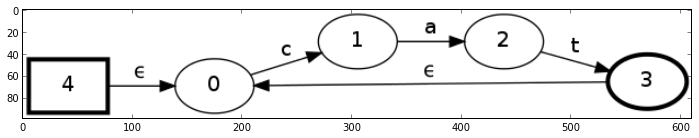

In [66]:
openfst.ClosureStar(a)
show_fst(a)

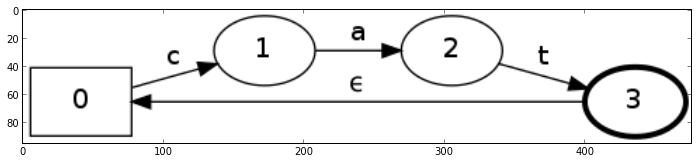

In [67]:
a = FST()
a.AddString("cat")
openfst.ClosurePlus(a)
show_fst(a)

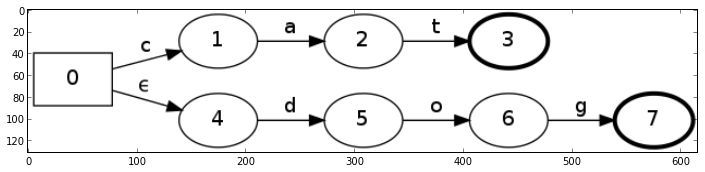

In [68]:
a = FST()
a.AddString("cat")
b = FST()
b.AddString("dog")
openfst.Union(a,b)
show_fst(a)

# Weights

The weights in these computations are usually floating numbers, but with a pair of operations forming a "tropical semiring".

In [69]:
w = openfst.Weight_Zero()
print w.Value()
w = openfst.Weight_One()
print w.Value()

inf
0.0


The operations are those used for combining paths when they merge and for combining weights along a path.

Common choices are (addition / multiplication / zero / one)

- boolean: OR / AND / FALSE / TRUE (possibilities)
- real: $+$ / $*$ / 0 / 1 (probabilities)
- log: $-\log(e^x+e^y)$ / $+$ / inf / 0 (log probabilities, costs)
- tropical: $\min$ / $+$ / inf / 0 (log probabilities, Viterbi)

Remember that these operations reduce to computations on conditional probabilities,
either computing the maximum probability (minimum cost) to reach a node (Viterbi algorithm), 
or the total probability for reaching a node (forward algorithm).



# Infinite Sets of Strings and Sampling

Let's construct a transducer corresponding to "(cat|dog)+(ant|elk)+".

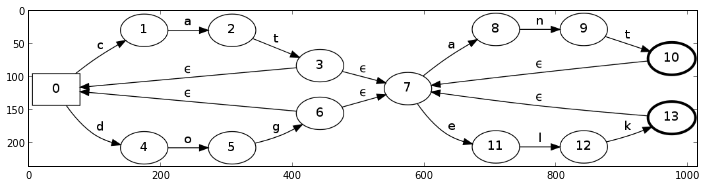

In [70]:
a = FST()
a.AddString("cat")
a.AddString("dog")
openfst.ClosurePlus(a)
b = FST()
b.AddString("ant")
b.AddString("elk")
openfst.ClosurePlus(b)
openfst.ConcatOnto(a,b)
show_fst(a)

As we said above, finite state transducers are collections of strings.
We can pick a random sample from this collection with the `RandGen` function.

In [71]:
out = FST()
openfst.RandGen(a,out)
print openfst.GetString(out)

catant


Written like that, the sampling algorithm makes a uniformly random choice at each node.

Since weights usually represent log probabilities, we may want to sample according to those.
To do that, use `RandGen` and the `LogProbArcSelector`.

# Epsilon Removal

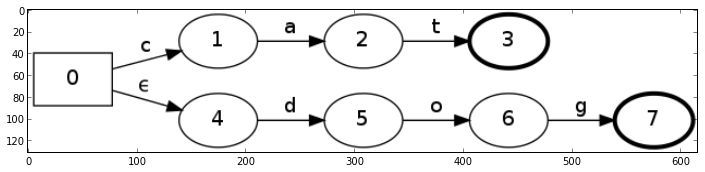

In [72]:
a = FST()
a.AddString("cat")
b = FST()
b.AddString("dog")
openfst.Union(a,b)
show_fst(a)

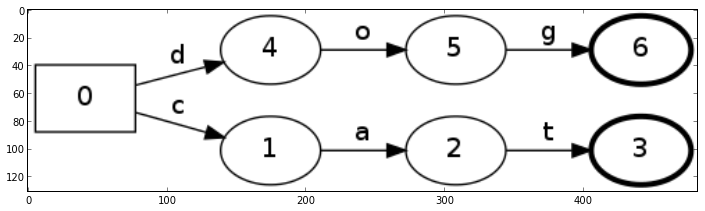

In [73]:
openfst.RmEpsilon(a)
show_fst(a)

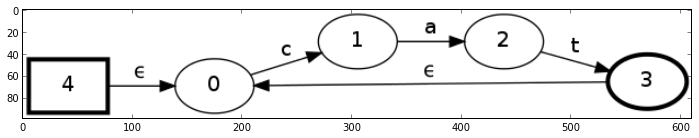

In [74]:
a = FST()
a.AddString("cat")
openfst.ClosureStar(a)
show_fst(a)

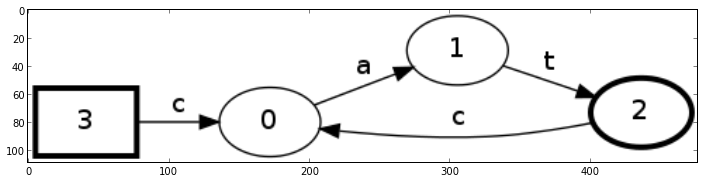

In [75]:
openfst.RmEpsilon(a)
show_fst(a)

Note that `RmEpsilon` removes transitions that have epsilon on both the input and the output.
It gets more complicated when there are epsilons only on inputs or only on outputs.

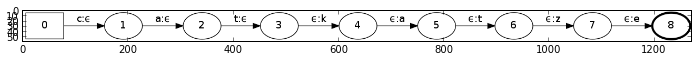

In [76]:
a = FST()
a.AddTranslation("cat","katze")
show_fst(a)

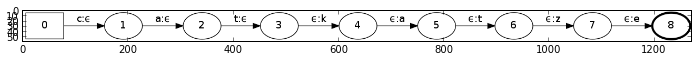

In [77]:
out = a.Copy()
openfst.RmEpsilon(out)
show_fst(out)

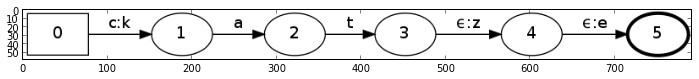

In [78]:
out = FST()
openfst.EpsNormOutput(a,out)
show_fst(out)

# Determinization and Minimization

What makes finite state transducers so powerful is a number of operations that
work generically on even very large and complex transducers.

Foremost among these are determinization and minimization.

## Unweighted, Acyclic

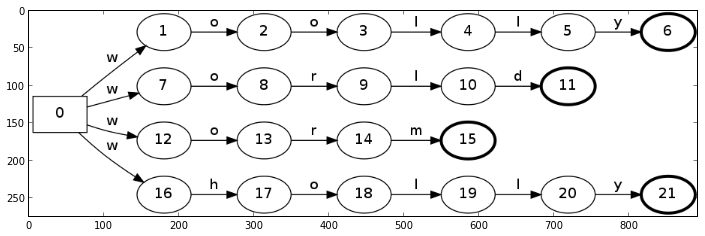

In [79]:
fst = FST()
fst.AddString("woolly")
fst.AddString("world")
fst.AddString("worm")
fst.AddString("wholly")
show_fst(fst)

The above machine is *non-deterministic*: starting in node 0, there are multiple arcs we can take, all labeled the same.

We can determinize this structure using `openfst.Determinize`.
This yields a finite state transducer that is equivalent to a data structure called a *trie*.

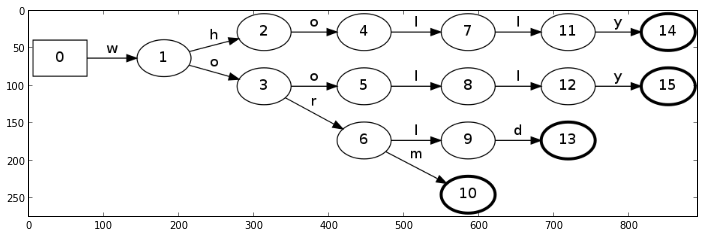

In [80]:
dfst = FST()
openfst.Determinize(fst,dfst)
show_fst(dfst)

We can compact this data structure further by minimization.

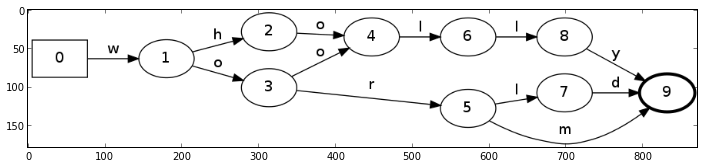

In [81]:
openfst.Minimize(dfst)
show_fst(dfst)

In [82]:
print fstsize(fst)
print fstsize(dfst)

(22, 21)
(10, 12)


In [83]:
def minimize(fst):
    dfst = FST()
    openfst.Determinize(fst,dfst)
    openfst.Minimize(dfst)
    return dfst

Let's try to do this for something larger.

In [126]:
fst = FST()
nlines = 0
with open("basic-english.txt") as stream:
    for line in stream.readlines():
        line = line.strip()
        fst.AddString(line)
        nlines += 1
print nlines
print fstsize(fst)
fst = minimize(fst)
print fstsize(fst)

851
(4459, 4458)
(746, 1541)


## Weighted, Acyclic

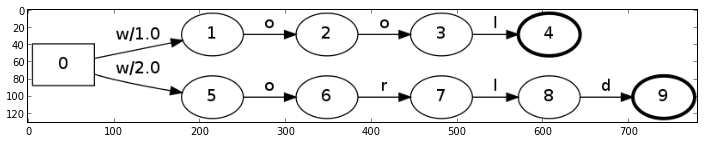

In [85]:
fst = FST()
fst.AddString("wool",1.0)
fst.AddString("world",2.0)
show_fst(fst)

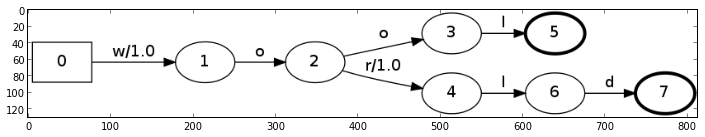

In [86]:
dfst = FST()
openfst.Determinize(fst,dfst)
show_fst(dfst)

## Weighted, Not Acyclic

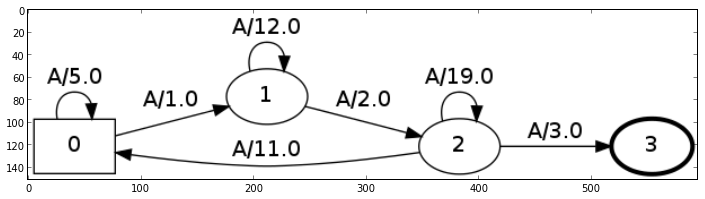

In [87]:
fst = FST()
S = [fst.AddState() for i in range(4)]
for i in range(3):
    fst.AddArc(S[i],65,65,i+1,S[i+1])
    fst.AddArc(S[i],65,65,7*i+5,S[i])
fst.AddArc(S[2],65,65,11,S[0])
fst.SetStart(S[0])
fst.SetFinal(S[-1],0)
show_fst(fst)

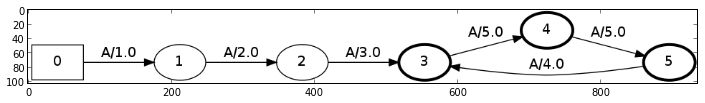

In [88]:
dfst = FST()
openfst.Determinize(fst,dfst)
show_fst(dfst)

## Termination and Complexity

Note that there are **determinizable** and **non-determinizable** automata.
`Determinize` will not terminate on non-determinizable automata.

The following are always determinizable:

- unweighted automata
- acyclic automata

Again, if you give `Determinize` a bad input, it will just sit there eating up memory until it crashes.

Once determinized, minimization works and has the following complexities:

- acyclic: $O(E)$
- unweighted: $O(E \log V)$
- weighed: complexity of "shortest distance algorithm" + complexity of unweighted minimization

# Intersection

In [89]:
def wordset(s):
    fst = FST()
    for w in s.split():
        fst.AddString(w)
    return fst

In [90]:
a = wordset("there is a fox on the lot")
b = wordset("the quick brown fox does a lot of jumping")

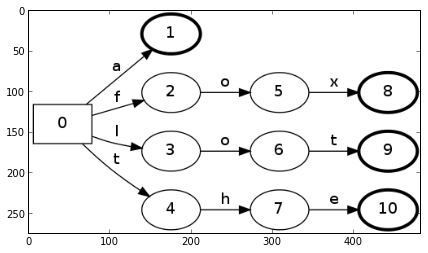

In [91]:
out = FST()
# must sort prior to Intersect, otherwise it crashes with an error
openfst.ArcSortInput(a)
openfst.ArcSortInput(b)
openfst.Intersect(a,b,out)
show_fst(out)

# Composition

## Composition Like Intersection

In [92]:
a = wordset("there is a fox on the lot")
b = wordset("the quick brown fox does a lot of jumping")

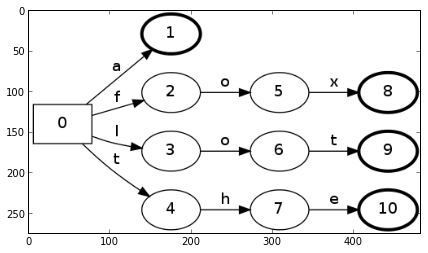

In [93]:
out = FST()
# must sort prior to Intersect, otherwise it crashes with an error
openfst.ArcSortOutput(a)
openfst.ArcSortInput(b)
openfst.Compose(a,b,out)
show_fst(out)

## Composition for "Translation"

In [94]:
def getc(w,i):
    if i>=len(w): return 0
    return ord(w[i])
def add_between(fst,u,v,inword,outword):
    n = max(len(inword),len(outword))
    S = [u]+[fst.AddState() for i in range(n-1)]+[v]
    for i in range(n):
        fst.AddArc(S[i],getc(inword,i),getc(outword,i),0,S[i+1])
    return fst

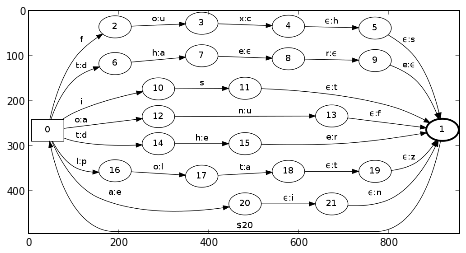

In [95]:
trans = FST()
s0 = trans.AddState()
trans.SetStart(s0)
s1 = trans.AddState()
trans.SetFinal(s1,0)
trans.AddArc(s1,32,32,0,s0)
add_between(trans,s0,s1,"fox","fuchs")
add_between(trans,s0,s1,"there","da")
add_between(trans,s0,s1,"is","ist")
add_between(trans,s0,s1,"on","auf")
add_between(trans,s0,s1,"the","der")
add_between(trans,s0,s1,"lot","platz")
add_between(trans,s0,s1,"a","ein")
show_fst(trans)

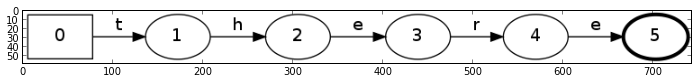

In [96]:
a = FST()
a.AddString("there")
show_fst(a)

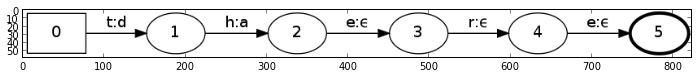

In [97]:
out = FST()
# must sort prior to Intersect, otherwise it crashes with an error
openfst.ArcSortOutput(a)
openfst.ArcSortInput(trans)
openfst.Compose(a,trans,out)
show_fst(out)

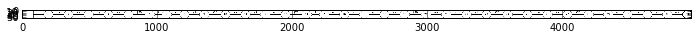

In [98]:
a = FST()
a.AddString("there is a fox on the lot")
out = FST()
# must sort prior to Intersect, otherwise it crashes with an error
openfst.ArcSortOutput(a)
openfst.ArcSortInput(trans)
openfst.Compose(a,trans,out)
show_fst(out)

In [99]:
print label_seq(out)

da ist ein fuchs auf der platz


In [100]:
openfst.GetString(out)

'da ist ein fuchs auf der platz'

# Blow-Up on "Minimization"

Let's minimize the above "translator".

(22, 28)
(54, 95)


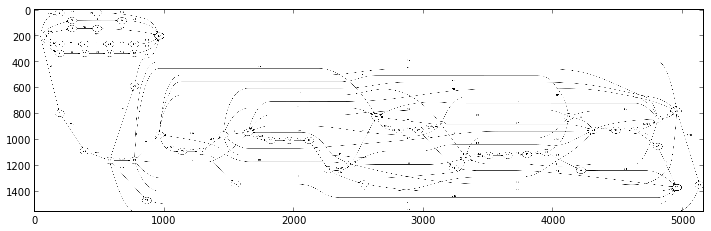

In [101]:
dfst = FST()
openfst.Determinize(trans,dfst)
openfst.Minimize(dfst)
show_fst(dfst)
print fstsize(trans)
print fstsize(dfst)

As you can see, the "minimized" automaton is bigger than the original one.
That is because minimization actually starts off with determinization, which
can increase the size of the automaton.
Nevertheless, a deterministic minimal automaton may still be preferable
to a smaller non-deterministic automaton.

# Difference

In addition to intersection, union, and composition, you also get the "difference" operation.
Again, it is best to think of this as difference of sets of strings.

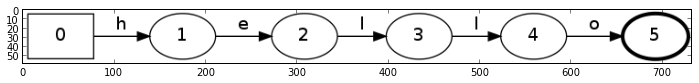

In [102]:
a = FST()
a.AddString("hello")
a.AddString("world")
b = FST()
b.AddString("world")
out = FST()
openfst.Difference(a,b,out)
show_fst(out)

Note that in the presence of cycles, this can get quite complicated.

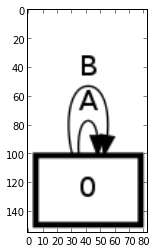

In [103]:
a = FST()
S = a.AddState()
a.SetStart(S)
a.SetFinal(S,0)
a.AddArc(S,65,65,0,S)
a.AddArc(S,66,66,0,S)
show_fst(a)

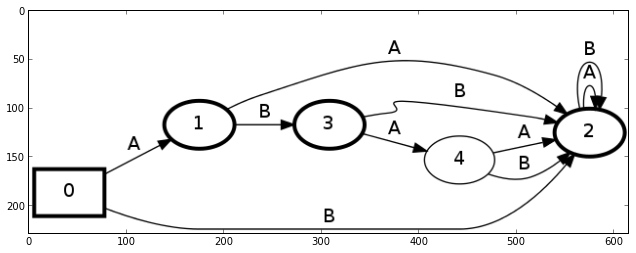

In [104]:
b = FST()
b.AddString("ABA")
out = FST()
openfst.Difference(a,b,out)
show_fst(out)

Note that `Difference` works only on unweighted epsilon-free deterministic acceptors.

# Reverse

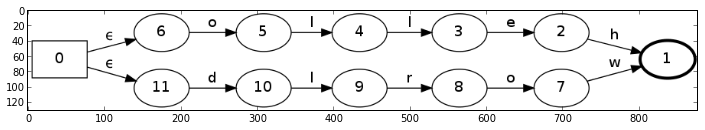

In [105]:
a = FST()
a.AddString("hello")
a.AddString("world")
out = FST()
openfst.Reverse(a,out)
show_fst(out)

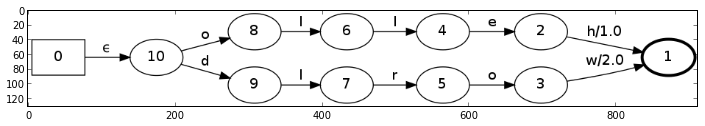

In [106]:
a = FST()
a.AddString("hello",1.0)
a.AddString("world",2.0)
a = minimize(a)
out = FST()
openfst.Reverse(a,out)
show_fst(out)

# Transducer Labels

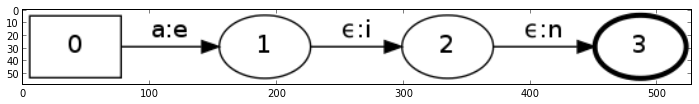

In [107]:
a = FST()
a.AddTranslation("a","ein")
a = minimize(a)
openfst.RmEpsilon(a)
show_fst(a)

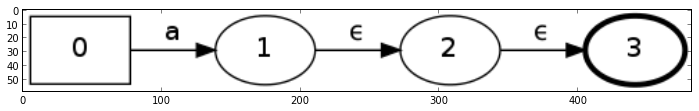

In [108]:
out = a.Copy()
openfst.ProjectInput(out)
show_fst(out)

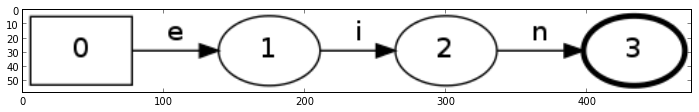

In [109]:
out = a.Copy()
openfst.ProjectOutput(out)
show_fst(out)

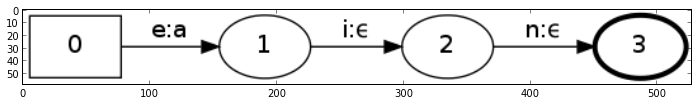

In [110]:
out = a.Copy()
openfst.Invert(out)
show_fst(out)

# Arc Sorting

For some of the operations, like `Compose`, we needed to call
an `ArcSort` operation.
This is because inside the `Compose` function, lists of arcs
are compared in an operation similar to a sorted merge.

Here is a simple illustration of what `ArcSort` does.

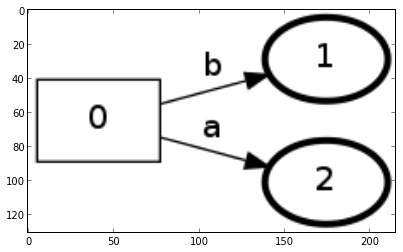

In [111]:
a = FST()
a.AddString("b")
a.AddString("a")
show_fst(a)

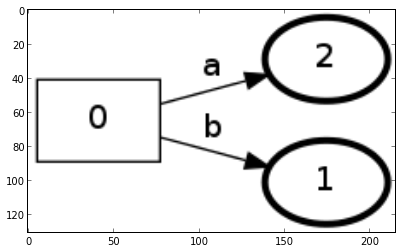

In [112]:
openfst.ArcSortInput(a)
show_fst(a)

# Topological Sort

Topological sorting renumbers the nodes of the graph so that they are consistent
with some depth-first search exploration of the graph from the start state.

This is an important operation inside the library; I mainly mention it here
because you should review topological sorting from your algorithms class.

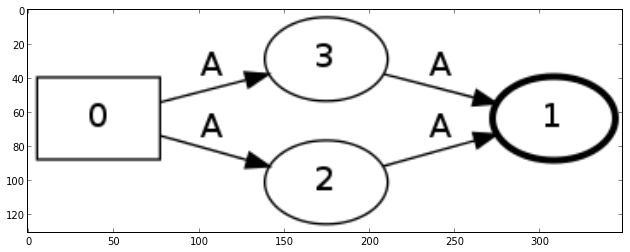

In [113]:
a = FST()
S = [a.AddState() for i in range(4)]
a.AddArc(0,65,65,0,3)
a.AddArc(0,65,65,0,2)
a.AddArc(3,65,65,0,1)
a.AddArc(2,65,65,0,1)
a.SetFinal(1,0)
a.SetStart(0)
show_fst(a)

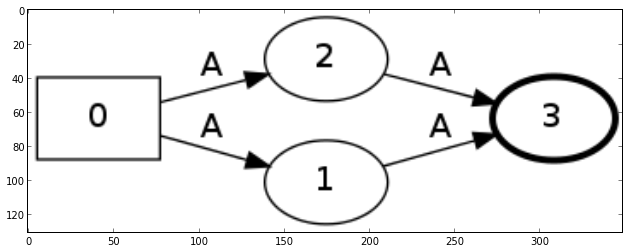

In [114]:
openfst.TopSort(a)
show_fst(a)

# Shortest Paths

`ShortestPath` computes the shortest path through the weighted finite state transducer,
starting at the start state and fininishing at some final state.

This uses the common shortest path graph algorithms. Which algorithm is used
depends on the properties of the FST.

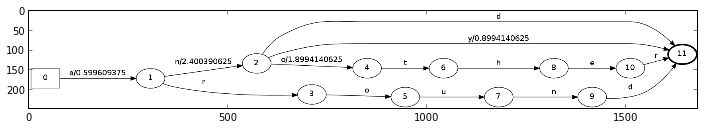

In [115]:
a = FST()
a.AddString("and",0,0,1)
a.AddString("another",0,0,0.7)
a.AddString("any",0,0,1.3)
a.AddString("around",0,0,0.1)
a = minimize(a)
show_fst(a)

In [116]:
out = FST()
openfst.ShortestPath(a,out,1)
label_seq(out,full=1)

(['a', 'r', 'o', 'u', 'n', 'd'], 0.599609375)

# Shortest Distance

`ShortestDistance` computes the distance from the start node to each node
in the graph and puts the result into an array.

This turns out to be a very powerful operation that we will be talking about
again later.

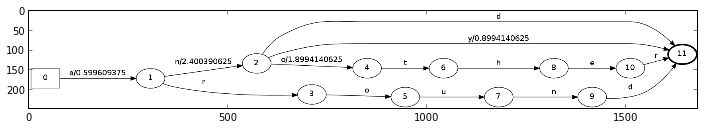

In [117]:
a = FST()
a.AddString("and",0,0,1)
a.AddString("another",0,0,0.7)
a.AddString("any",0,0,1.3)
a.AddString("around",0,0,0.1)
a = minimize(a)
show_fst(a)

In [118]:
dist = openfst.vector_weight()
openfst.ShortestDistance(a,dist,0)
print [d.Value() for d in dist]

[0.0, 0.599609375, 3.0, 0.599609375, 4.8994140625, 0.599609375, 4.8994140625, 0.599609375, 4.8994140625, 0.599609375, 4.8994140625, 0.599609375]


# Back to Language Models

Let's construct a simple language model again.

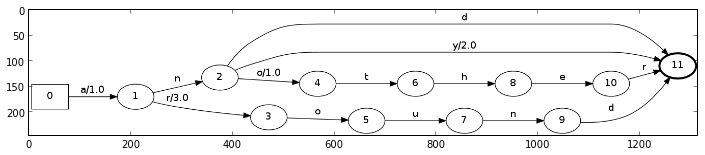

In [119]:
a = FST()
a.AddString("and",1)
a.AddString("another",2)
a.AddString("any",3)
a.AddString("around",4)
a = minimize(a)
show_fst(a)

In [120]:
class WfstLanguageModel:
    def __init__(self,fst):
        self.fst = fst
    def cost(self,s):
        global composed,shortest
        # construct a finite state transducer corresponding to the string
        a = FST()
        a.AddString(s)
        # compose the string model with the language model
        composed = FST()
        openfst.Compose(a,self.fst,composed)
        if composed.NumStates()==0: return inf
        # find the shortest path in the composition
        shortest = FST()
        openfst.ShortestPath(composed,shortest,1)
        if shortest.NumStates()==0: return inf
        # output the cost
        out,cost = label_seq(shortest,full=1)
        return cost

In [121]:
lm = WfstLanguageModel(a)

In [122]:
lm.cost("any")

3.0

In [123]:
lm.cost("foo")

inf

The real power from these kinds of language models derives from the fact that we can actually test multiple recognition hypotheses at the same time.

Assume that for some input, a recognizer (OCR engine etc.) generated two hypotheses with
different costs: "ary" and "any".
These hypothese are put into an WFST (how that happens depends on the recognizer).

We call the resulting FST a *hypothesis graph* or a *recognition lattice*.

In [124]:
hypotheses = FST()
hypotheses.AddString("ary",0.3)
hypotheses.AddString("any",1.7)

We now compose the recognition lattice with the language model,
and we get out the optimal answer that is compatible with the language model.

In [125]:
composed = FST()
openfst.Compose(hypotheses,lm.fst,composed)
shortest = FST()
openfst.ShortestPath(composed,shortest,1)
label_seq(shortest,full=1)

(['a', 'n', 'y'], 4.700000047683716)